# Detectron2 Inference

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os

sys.path.append("../../src/")

from utils import rle_decode
from monkey_patches import *
from metrics import iou_map

from detectron2_src.d2_pipelines import *

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.engine import BestCheckpointer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import detection_utils as utils
from detectron2.utils.logger import setup_logger
import detectron2.data.transforms as T
import detectron2
setup_logger()

<Logger detectron2 (DEBUG)>

In [7]:
# Locations & Information
detectron2_models_dir = [
    "../../models/detectron2_models/model_0.pth",
    "../../models/detectron2_models/model_1.pth",
    "../../models/detectron2_models/model_2.pth"
]

data_dir = "../../data/"

actual_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

image_ids = [
    "0ea6df67cc77",
    "174793807517",
    "22e0c43da285",
    "44e1c6996c16",
    "5bbf4c20aad2",
    "5c252798d269",
    "6867e380fe3c",
    "74bb773bab01",
    "7b2818817d0d",
    "9ae46e01286c",
    "a96cf05207fc",
    "b03de5cbebb2",
    "b81db12284ff",
    "bfb878cd992e",
    "dd8bcbe5094b",
    "de504eaa5349",
    "df54ca550ecd",
    "e4f28f1ea4ee",
    "e96b5ddfef20"
]

In [13]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.INPUT.MASK_FORMAT = "bitmask"

cfg.MODEL.WEIGHTS = detectron2_models_dir[0]
predictor_0 = DefaultPredictor(cfg)

# More if you want to ensemble.
#cfg.MODEL.WEIGHTS = detectron2_models_dir[1]
#predictor_1 = DefaultPredictor(cfg)

#cfg.MODEL.WEIGHTS = detectron2_models_dir[2]
#predictor_2 = DefaultPredictor(cfg)


2022-01-05 20:41:38,980 [INFO] [Checkpointer] Loading from ../../models/detectron2_models/model_0.pth ...
2022-01-05 20:41:39,547 [INFO] [Checkpointer] Loading from ../../models/detectron2_models/model_1.pth ...
2022-01-05 20:41:40,611 [INFO] [Checkpointer] Loading from ../../models/detectron2_models/model_2.pth ...


In [15]:
def plot_pred_actual(pred, actual, show = True):
    """
    | ======= | ======= | 
    |    P    |    A    | 
    | ======= | ======= | 
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

    ax1.set_title("Prediction")
    ax1.imshow(pred)

    ax2.set_title("Actual")
    ax2.imshow(actual)

    if show: plt.show()

0ea6df67cc77 | Score: 0.18040206015234017


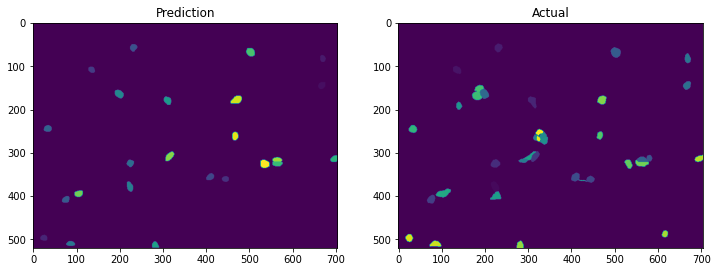

174793807517 | Score: 0.17447286231223064


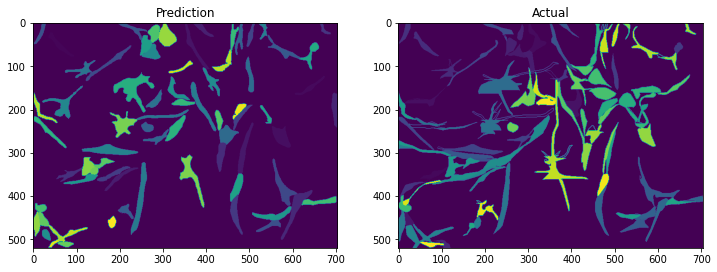

22e0c43da285 | Score: 0.11484723450240693


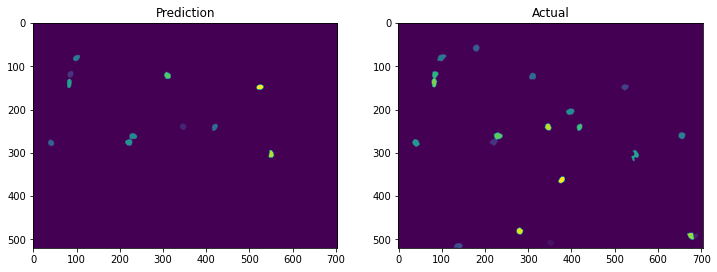

44e1c6996c16 | Score: 0.1842376418135561


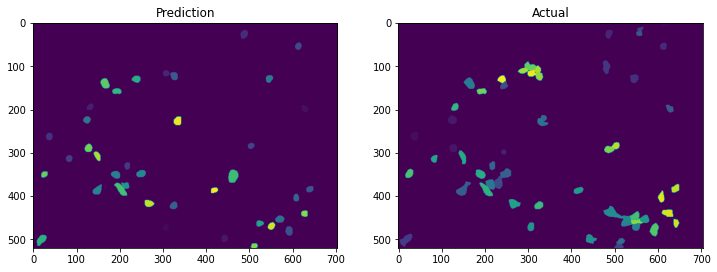

5bbf4c20aad2 | Score: 0.11126715853297275


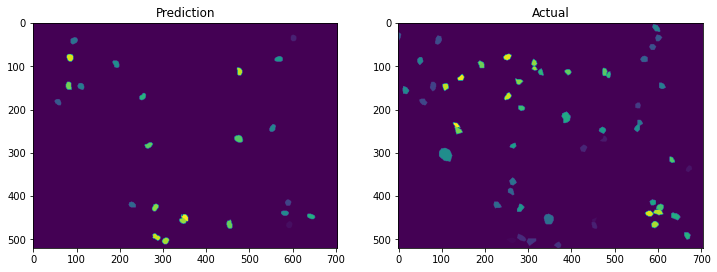

5c252798d269 | Score: 0.12129981522986062


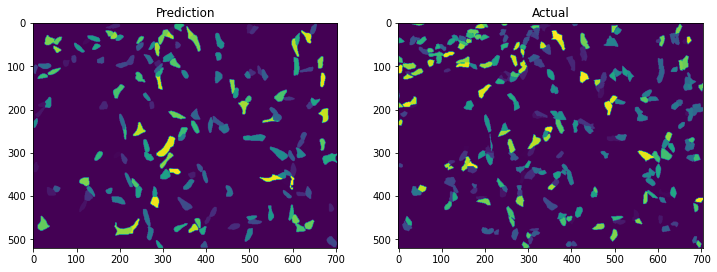

6867e380fe3c | Score: 0.308820749747736


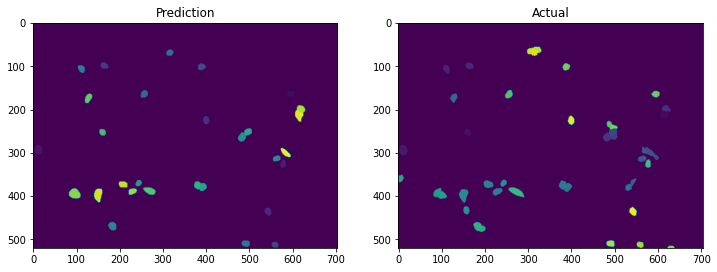

74bb773bab01 | Score: 0.08168864029807157


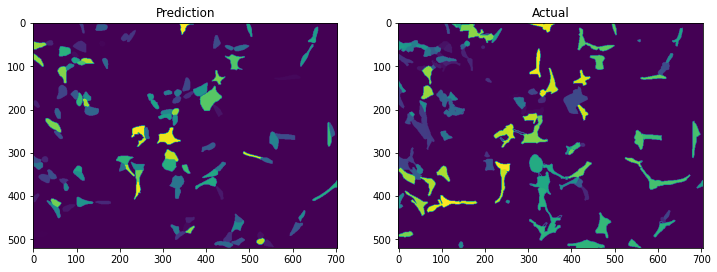

7b2818817d0d | Score: 0.09848226424422198


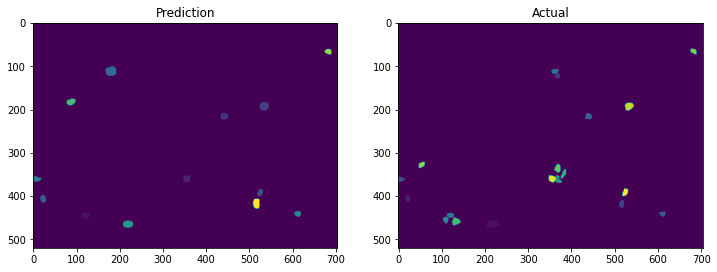

9ae46e01286c | Score: 0.27933846666512563


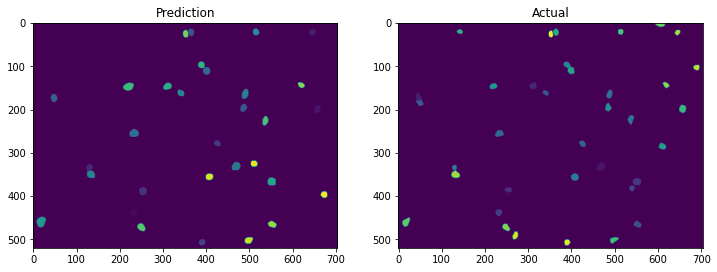

a96cf05207fc | Score: 0.3007238356331182


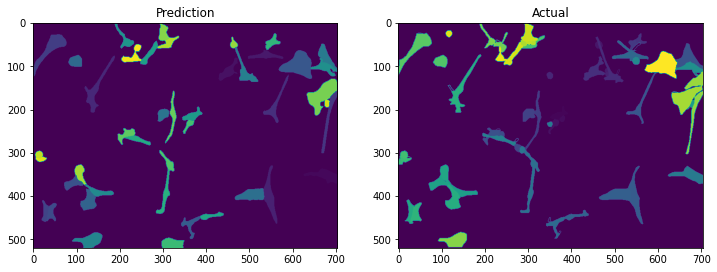

b03de5cbebb2 | Score: 0.0899827125005471


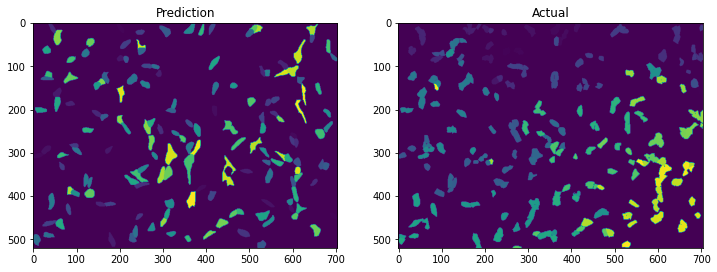

b81db12284ff | Score: 0.14771120689655173


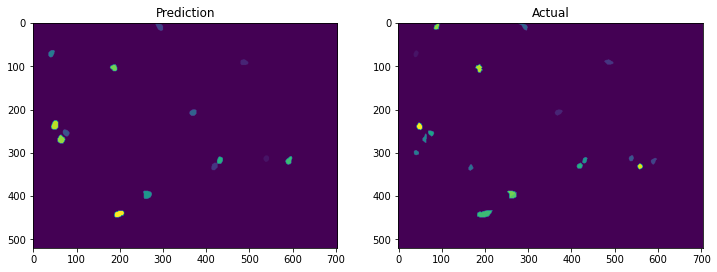

bfb878cd992e | Score: 0.13935000685691457


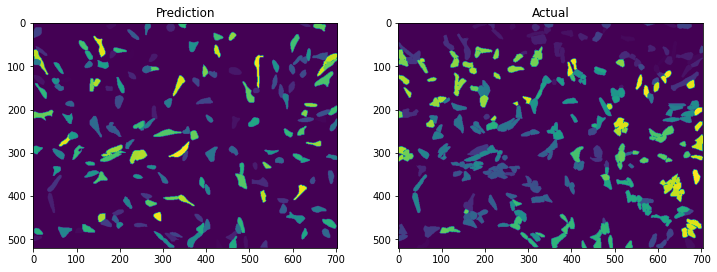

dd8bcbe5094b | Score: 0.27730481792862166


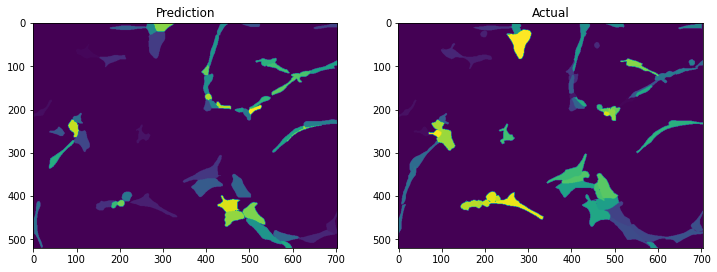

In [ ]:
cell_scores = {
    "cort"   : [],
    "astro"  : [],
    "shsy5y" : []
}

scores = []
for image_id in image_ids:
    image_dir = os.path.join(data_dir, f"train/{image_id}.png")

    image_grey = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    image_rgb  = cv2.imread(image_dir)
    
    cfg = load_yaml("../../src/detectron2_src/d2_config.yaml")

    output_0 = predictor_0(image_rgb)
    #output_1 = predictor_1(image_rgb)
    #output_2 = predictor_2(image_rgb)
    
    det2_pred = detectron2_pipeline(output_0, cfg)

#    det2_pred = detectron2_pipeline_ensemble_nms([output_0, output_1, output_2], cfg)
#    det2_pred = detectron2_pipeline_nms(output_0, cfg)

    actual_id_df = actual_df[actual_df["id"] == image_id]

    cell_type    = actual_id_df["cell_type"].tolist()[0]
    annotations  = actual_id_df["annotation"].tolist()

    actual = rle_decode(annotations).astype(np.uint16)

    score = iou_map([det2_pred], [actual], verbose = False)

    scores.append(score)
    cell_scores[cell_type].append(score)

    print(f"{image_id} | Score: {score}")

    plot_pred_actual(det2_pred, actual, show = True)

cort_score   = np.mean(cell_scores["cort"])
astro_score  = np.mean(cell_scores["astro"])
shsy5y_score = np.mean(cell_scores["shsy5y"])

print(f"MAP IoU: {np.mean(scores)}")
print(f"Cort   | Score: {cort_score}")
print(f"Astro  | Score: {astro_score}")
print(f"Shsy5y | Score: {shsy5y_score}")